In [1]:
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

2025-04-22 18:40:49.574901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745361649.586625  282901 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745361649.591090  282901 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745361649.601191  282901 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745361649.601204  282901 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745361649.601206  282901 computation_placer.cc:177] computation placer alr

In [2]:
tf.config.list_physical_devices('GPU')

2025-04-22 18:40:50.969195: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-04-22 18:40:50.969211: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-04-22 18:40:50.969215: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: pop-os
2025-04-22 18:40:50.969217: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: pop-os
2025-04-22 18:40:50.969250: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 570.133.7
2025-04-22 18:40:50.969262: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported version is: 570.133.7
2025-04

[]

In [3]:
def create_data_generator(data_dir, image_height, image_width, channels):
    data_dir = Path(data_dir)
    categories = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
    category_to_index = {cat: idx for idx, cat in enumerate(categories)}
    image_label_paths = []
    for cat in categories:
        folder = data_dir / cat
        for ext in ('*.jpg', '*.jpeg', '*.png'):
            for image_path in folder.glob(ext):
                image_label_paths.append((image_path, category_to_index[cat]))
    def generator():
        for image_path, label_index in image_label_paths:
            img_data = tf.io.read_file(str(image_path))
            img = tf.image.decode_image(img_data, channels=channels)
            img.set_shape([None, None, channels])
            img = tf.image.resize(img, [image_height, image_width])
            img = tf.cast(img, tf.float32) / 255.0
            label = tf.one_hot(label_index, depth=len(categories))
            yield img, label
    return generator, len(categories), len(image_label_paths), categories

def create_model(num_classes, image_height, image_width, channels):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu',
                               input_shape=(image_height, image_width, channels)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax'),
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

In [4]:
IMAGE_HEIGHT = 400
IMAGE_WIDTH = 400
IMAGE_CHANNELS = 3
BATCH_SIZE = 16

In [5]:
data_dir = '../data/sorted_images'

print('TensorFlow version:', tf.__version__)

generator, num_classes, size, categories = create_data_generator(
    data_dir, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
print(f'Found {size} images belonging to {num_classes} classes: {categories}')

TensorFlow version: 2.19.0
Found 3914 images belonging to 6 classes: ['certification', 'icons', 'logo', 'other', 'people', 'project image']


In [6]:
dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
    )
)
# dataset = dataset.take(int(size*0.5))
dataset = dataset.shuffle(size)

train_size = int(size * 0.8)
train_ds = dataset.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = dataset.skip(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
model = create_model(num_classes, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

/home/daniel/Desktop/Coding/thundrmodels/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 398, 398, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 199, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 197, 197, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 294912)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    37,748,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,850,758 (144.39 MB)

 Trainable params: 37,850,758 (144.39 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# model = tf.keras.models.load_model("../models/imagezap.keras")

In [9]:
history = model.fit(train_ds,
            epochs=10,
            validation_data=val_ds)

Epoch 1/10


2025-04-22 18:41:02.092164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3620 of 3914
2025-04-22 18:41:03.094049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


    196/Unknown 206s 990ms/step - accuracy: 0.3951 - loss: 2.4908

2025-04-22 18:44:17.263508: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/daniel/Desktop/Coding/thundrmodels/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-04-22 18:44:27.362576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3869 of 3914
2025-04-22 18:44:27.501412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.3954 - loss: 2.4865 - val_accuracy: 0.5939 - val_loss: 1.2228
Epoch 2/10


2025-04-22 18:44:37.282491: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 18:44:47.686356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3882 of 3914
2025-04-22 18:44:47.782354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5274 - loss: 1.2312

2025-04-22 18:48:23.890930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3506 of 3914
2025-04-22 18:48:25.378214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.5274 - loss: 1.2312 - val_accuracy: 0.6181 - val_loss: 1.0200
Epoch 3/10


2025-04-22 18:48:35.233372: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 18:48:45.631819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3862 of 3914
2025-04-22 18:48:45.788886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 958ms/step - accuracy: 0.5588 - loss: 1.1154

2025-04-22 18:52:04.123322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3845 of 3914
2025-04-22 18:52:04.329183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.5589 - loss: 1.1153 - val_accuracy: 0.6501 - val_loss: 0.8748
Epoch 4/10


2025-04-22 18:52:24.219991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3904 of 3914
2025-04-22 18:52:24.249995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 981ms/step - accuracy: 0.6220 - loss: 0.9710

2025-04-22 18:55:47.128311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3877 of 3914
2025-04-22 18:55:47.239274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.6220 - loss: 0.9711 - val_accuracy: 0.7139 - val_loss: 0.7981
Epoch 5/10


2025-04-22 18:55:56.662937: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-22 18:56:07.121499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3846 of 3914
2025-04-22 18:56:07.326001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - accuracy: 0.6540 - loss: 0.9395

2025-04-22 18:59:26.721137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3887 of 3914
2025-04-22 18:59:26.801863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.6540 - loss: 0.9394 - val_accuracy: 0.7407 - val_loss: 0.7231
Epoch 6/10


2025-04-22 18:59:46.765136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3894 of 3914
2025-04-22 18:59:46.825692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.6968 - loss: 0.8499

2025-04-22 19:03:03.470363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3837 of 3914
2025-04-22 19:03:03.701359: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.6968 - loss: 0.8498 - val_accuracy: 0.7637 - val_loss: 0.6846
Epoch 7/10


2025-04-22 19:03:23.636790: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3852 of 3914
2025-04-22 19:03:23.823182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.7285 - loss: 0.7457

2025-04-22 19:06:43.993352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3822 of 3914
2025-04-22 19:06:44.272688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.7285 - loss: 0.7457 - val_accuracy: 0.7420 - val_loss: 0.6887
Epoch 8/10


2025-04-22 19:07:04.003200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3633 of 3914
2025-04-22 19:07:05.917696: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7490 - loss: 0.7148

2025-04-22 19:10:38.216692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3603 of 3914
2025-04-22 19:10:39.295428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.7490 - loss: 0.7147 - val_accuracy: 0.8378 - val_loss: 0.4610
Epoch 9/10


2025-04-22 19:10:48.752809: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 976ms/step - accuracy: 0.7645 - loss: 0.6228

2025-04-22 19:14:20.930882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3826 of 3914
2025-04-22 19:14:21.193670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.7645 - loss: 0.6227 - val_accuracy: 0.8685 - val_loss: 0.3961
Epoch 10/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.7994 - loss: 0.5572

2025-04-22 19:17:59.199553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3882 of 3914
2025-04-22 19:17:59.296391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


196/196 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.7994 - loss: 0.5574 - val_accuracy: 0.8289 - val_loss: 0.4417


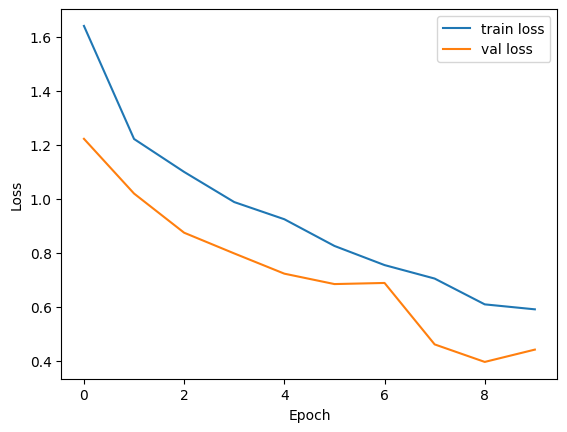

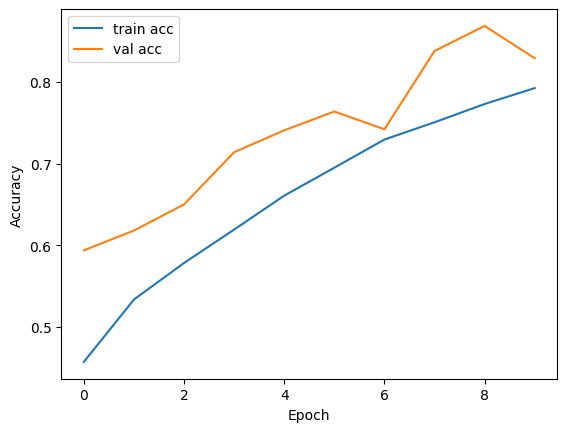

In [10]:
# Plot training & validation loss
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [15]:
with Image.open("../data/test.png") as img:
    # Ensure image is in RGBA for proper transparency handling
    img = img.convert("RGBA")
    # Create a new 400x400 background with pink color
    bg_color = (255, 39, 255)
    new_img = Image.new("RGB", (400, 400), bg_color)
    
    img.thumbnail((400, 400), Image.LANCZOS)
    # Calculate coordinates to center the image on the background
    left = (400 - img.width) // 2
    top = (400 - img.height) // 2
    # Paste the resized image onto the off-gray background using the image's alpha channel as mask
    new_img.paste(img, (left, top), img)

    new_img.save("../data/test_output.png")

img_data = tf.io.read_file("../data/test_output.png")
img_data = tf.image.decode_image(img_data, channels=IMAGE_CHANNELS)
img_data.set_shape([None, None, IMAGE_CHANNELS])
img_data = tf.image.resize(img_data, [IMAGE_HEIGHT, IMAGE_WIDTH])
img_data = tf.cast(img_data, tf.float32) / 255.0


In [16]:
categories

['certification', 'icons', 'logo', 'other', 'people', 'project image']

In [17]:
model.predict(np.array([img_data]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


array([[2.4818587e-01, 1.3120392e-03, 7.1627980e-01, 3.4164935e-02,
        3.6403220e-05, 2.0909278e-05]], dtype=float32)

In [18]:
model.save("../models/imagezap.keras")